# DeepLearning

## MNIST Dataset using DeepWater and Custom MXNet Model

The MNIST database is a well-known academic dataset used to benchmark
classification performance. The data consists of 60,000 training images and
10,000 test images. Each image is a standardized $28^2$ pixel greyscale image of
a single handwritten digit. An example of the scanned handwritten digits is
shown
![Example MNIST digit images](images/mnist.png)

In [1]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,2 hours 6 mins
H2O cluster version:,3.11.0.99999
H2O cluster version age:,9 hours and 12 minutes
H2O cluster name:,arno
H2O cluster total nodes:,1
H2O cluster free memory:,13.65 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [2]:
import os.path
PATH = os.path.expanduser("~/h2o-3/")

In [3]:
test_df = h2o.import_file(PATH + "bigdata/laptop/mnist/test.csv.gz")

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


In [4]:
train_df = h2o.import_file(PATH + "/bigdata/laptop/mnist/train.csv.gz")

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


Specify the response and predictor columns

In [5]:
y = "C785"
x = train_df.names[0:784]

Convert the number to a class

In [6]:
train_df[y] = train_df[y].asfactor()
test_df[y] = test_df[y].asfactor()

Train Deep Learning model and validate on test set

### LeNET 1989

![lenet](./images/lenet.jpg)

In this demo you will learn how to build a simple LeNET Model usix MXNET.

In [7]:
def lenet(num_classes):
    import mxnet as mx
    data = mx.symbol.Variable('data')
    # first conv
    conv1 = mx.symbol.Convolution(data=data, kernel=(5,5), num_filter=20)
    tanh1 = mx.symbol.Activation(data=conv1, act_type="tanh")
    pool1 = mx.symbol.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))
    # second conv
    conv2 = mx.symbol.Convolution(data=pool1, kernel=(5,5), num_filter=50)
    tanh2 = mx.symbol.Activation(data=conv2, act_type="tanh")
    pool2 = mx.symbol.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))
    # first fullc
    flatten = mx.symbol.Flatten(data=pool2)
    fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
    tanh3 = mx.symbol.Activation(data=fc1, act_type="tanh")
    # second fullc
    fc2 = mx.symbol.FullyConnected(data=tanh3, num_hidden=num_classes)
    # loss
    lenet = mx.symbol.SoftmaxOutput(data=fc2, name='softmax')
    return lenet

In [8]:
nclasses = 10 

Here we instantiate our lenet model using 10 classes

In [9]:
mxnet_model = lenet(nclasses)

To import the model inside the DeepWater training engine we need to save the model to a file:

In [10]:
model_filename="/tmp/symbol_lenet-py.json"
mxnet_model.save(model_filename)

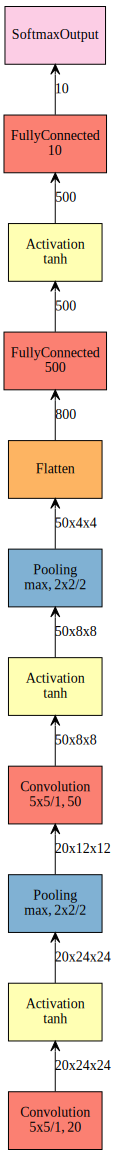

In [11]:
# pip install graphviz
# sudo apt-get install graphviz
import mxnet as mx
import graphviz
mx.viz.plot_network(mxnet_model, shape={"data":(1, 1, 28, 28)}, node_attrs={"shape":'rect',"fixedsize":'false'})

The model is just the structure of the network expressed as a json dict

In [12]:
!head -n 20 $model_filename

{
  "nodes": [
    {
      "op": "null", 
      "param": {}, 
      "name": "data", 
      "inputs": [], 
      "backward_source_id": -1
    }, 
    {
      "op": "null", 
      "param": {}, 
      "name": "convolution0_weight", 
      "inputs": [], 
      "backward_source_id": -1
    }, 
    {
      "op": "null", 
      "param": {}, 
      "name": "convolution0_bias", 


## Importing the LeNET model architecture for training in H2O

We have defined the model and saved the structure to a file. We are ready to start the training procedure.

In [13]:
from h2o.estimators.deepwater import H2ODeepWaterEstimator

In [14]:
lenet_model = H2ODeepWaterEstimator(
    epochs=10,
    learning_rate=1e-3, 
    mini_batch_size=64,
    network_definition_file=model_filename,
#    network='lenet',            ## equivalent pre-configured model
    image_shape=[28,28],
    problem_type='dataset',      ## Not 'image' since we're not passing paths to image files, but raw numbers
    ignore_const_cols=False,     ## We need to keep all 28x28=784 pixel values, even if some are always 0
    channels=1
)

In [15]:
lenet_model.train(x=train_df.names, y=y, training_frame=train_df, validation_frame=test_df)

deepwater Model Build progress: |█████████████████████████████████████████████████████████████| 100%


In [16]:
error = lenet_model.model_performance(valid=True).mean_per_class_error()
print "model error:", error

model error: 0.0200332124248


## A More powerful Architecture

the beauty of deeplearning is that we can compose a new model with even more "capacity" to try to get a higher accuracy.

In [17]:
def cnn(num_classes):
    import mxnet as mx
    data = mx.symbol.Variable('data')

    inputdropout = mx.symbol.Dropout(data=data, p=0.1)

    # first convolution
    conv1 = mx.symbol.Convolution(data=data, kernel=(5,5), num_filter=50)
    tanh1 = mx.symbol.Activation(data=conv1, act_type="relu")
    pool1 = mx.symbol.Pooling(data=tanh1, pool_type="max", pad=(1,1), kernel=(3,3), stride=(2,2))
    
    # second convolution
    conv2 = mx.symbol.Convolution(data=pool1, kernel=(5,5), num_filter=100)
    tanh2 = mx.symbol.Activation(data=conv2, act_type="relu")
    pool2 = mx.symbol.Pooling(data=tanh2, pool_type="max", pad=(1,1), kernel=(3,3), stride=(2,2))
    
    # first fully connected layer 
    flatten = mx.symbol.Flatten(data=pool2)
    fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=1024)
    relu3 = mx.symbol.Activation(data=fc1, act_type="relu")
    inputdropout = mx.symbol.Dropout(data=fc1, p=0.5)
    
    # second fully connected layer
    flatten = mx.symbol.Flatten(data=relu3)
    fc2 = mx.symbol.FullyConnected(data=flatten, num_hidden=1024)
    relu4 = mx.symbol.Activation(data=fc2, act_type="relu")
    inputdropout = mx.symbol.Dropout(data=fc2, p=0.5)
    
    # third fully connected layer
    fc3 = mx.symbol.FullyConnected(data=relu4, num_hidden=num_classes)
    # loss
    cnn = mx.symbol.SoftmaxOutput(data=fc3, name='softmax')
    return cnn

In [18]:
nclasses = 10

In [19]:
mxnet_model = cnn(nclasses)

In [20]:
model_filename="/tmp/symbol_cnn-py.json"
mxnet_model.save(model_filename)

In [21]:
from h2o.estimators.deepwater import H2ODeepWaterEstimator

In [22]:
print("Importing the lenet model architecture for training in H2O")

Importing the lenet model architecture for training in H2O


In [23]:
model = H2ODeepWaterEstimator(
    epochs=20, 
    learning_rate=1e-3, 
    mini_batch_size=64,
    network_definition_file=model_filename,
    image_shape=[28,28], 
    channels=1,
    ignore_const_cols=False    ## We need to keep all 28x28=784 pixel values, even if some are always 0
)

In [24]:
model.train(x=train_df.names, y=y, training_frame=train_df, validation_frame=test_df)

deepwater Model Build progress: |█████████████████████████████████████████████████████████████| 100%


In [25]:
error = model.model_performance(valid=True).mean_per_class_error()
print "model error:", error

model error: 0.0111236907698


## Visualizing the results

In [26]:
%matplotlib inline

import matplotlib
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from IPython.display import Image, display
import warnings
warnings.filterwarnings("ignore")

In [27]:
df = test_df.as_data_frame()

In [28]:
import numpy as np
image = df.T[int(np.random.random()*784)]

In [29]:
image.shape

(785,)

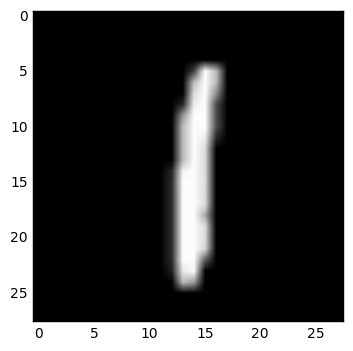

In [30]:
plt.imshow(image[:-1].reshape(28, 28), plt.cm.gray);

In [31]:
print image[-1]

1


In [32]:
image_hf = h2o.H2OFrame.from_python(image.to_dict())

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


In [33]:
prediction = model.predict(image_hf)

deepwater prediction progress: |██████████████████████████████████████████████████████████████| 100%


In [34]:
prediction['predict']

predict
1
